## 패키지 설치 및 모델, 이미지 불러오기

In [ ]:
# !pip install -q mediapipe

In [ ]:
# 원하는 모델 설치
# !wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [ ]:
# 이미지 다운로드
# !wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

## 모듈 불러오기

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = vision.FaceLandmarker
FaceLandmarkerOptions = vision.FaceLandmarkerOptions
VisionRunningMode = vision.RunningMode
FaceLandmarkerResult = vision.FaceLandmarkerResult  # 라이브 스트림에 사용

## 모델 선택 및 로컬 디렉터리에 저장

In [ ]:
model_path = '/absolute/path/to/face_landmarker.task'

## 작업 구성

In [ ]:
# 이미지 작업
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

In [ ]:
# 동영상 작업
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO)

In [ ]:
# 라이브 스트림 작업
def print_result(result: FaceLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    print('face landmarker result: {}'.format(result))

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.LIVE_STREAM,
    result_callback=print_result)

In [ ]:
with FaceLandmarker.create_from_options(options) as landmarker:
  # The landmarker is initialized. Use it here.
  # ...

## 데이터 준비

In [ ]:
# 이미지 작업
mp_image = mp.Image.create_from_file('image.png')

# 배열 이미지
# mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_image)

In [ ]:
# 동영상 작업

# OpenCV의 VideoCapture를 사용하여 입력 비디오 로드
# OpenCV의 CV_CAP_PROP_FPS를 사용하여 비디오의 프레임 속도를 로드(각 프레임의 타임스탬프를 계산하는 데 필요함)
# VideoCapture#read()를 사용하여 비디오의 각 프레임을 반복
# OpenCV에서 받은 프레임을 MediaPipe의 Image 객체로 변환
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)

In [ ]:
# 라이브 스트림 작업

# OpenCV의 VideoCapture를 사용하여 웹캠에서 캡처 시작
# VideoCapture#read()를 사용하여 카메라에서 최신 프레임을 읽는 루프 생성
# OpenCV에서 받은 프레임을 MediaPipe의 Image 객체로 변환
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)

## 작업 실행

In [ ]:
# 이미지 작업

# 제공된 단일 이미지에 대해 얼굴 랜드마크 수행
face_landmarker_result = landmarker.detect(mp_image)

In [ ]:
# 동영상 작업

# 제공된 단일 이미지에 대해 얼굴 랜드마크 수행
face_landmarker_result = landmarker.detect_for_video(mp_image, frame_timestamp_ms)

In [ ]:
# 라이브 스트림 작업

# 라이브 이미지 데이터를 전송하여 얼굴 랜드마크 수행
# 결과는 제공된 `result_callback`을 통해 액세스할 수 있음
# `FaceLandmarkerOptions` 객체.
landmarker.detect_async(mp_image, frame_timestamp_ms)

## 시각화 유틸리티

In [ ]:
# 필요한 모듈 임포트
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# 얼굴 랜드마크를 이미지에 그리는 함수 정의
def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    # 감지된 각 얼굴을 시각화
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        # 얼굴 랜드마크를 그리기 위해 프로토 형식으로 변환
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        # 각 랜드마크 포인트를 프로토 형식으로 변환하여 추가
        face_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        # 얼굴 랜드마크를 이미지에 그리기
        # 테셀레이션(삼각형 분할)을 그리는 설정
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())
        # 얼굴 윤곽선을 그리는 설정
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())
        # 홍채를 그리는 설정
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_iris_connections_style())

    return annotated_image

# 얼굴 블렌드쉐이프 바 그래프를 그리는 함수 정의
def plot_face_blendshapes_bar_graph(face_blendshapes):
    # 얼굴 블렌드쉐이프 카테고리 이름과 점수를 추출
    face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
    face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
    # 블렌드쉐이프는 점수 값에 따라 내림차순으로 정렬
    face_blendshapes_ranks = range(len(face_blendshapes_names))

    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(12, 12))
    bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
    ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
    ax.invert_yaxis()

    # 각 막대에 점수 라벨 추가
    for score, patch in zip(face_blendshapes_scores, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

    ax.set_xlabel('Score')
    ax.set_title("Face Blendshapes")
    plt.tight_layout()
    plt.show()


I0000 00:00:1719397120.687088   70382 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1719397120.687312   70382 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


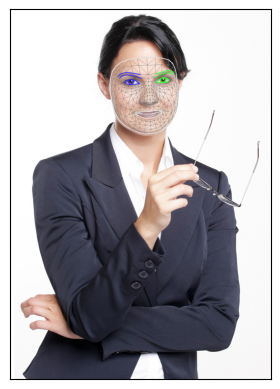

In [27]:
# STEP 1: 필요한 모듈 불러오기
import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: FaceLandmarker 개체 생성
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: 입력 이미지 불러오기
image = mp.Image.create_from_file("image.png")

# STEP 4: 입력 이미지에서 얼굴 랜드마크 감지
detection_result = detector.detect(image)

# STEP 5: 탐지 결과 처리(시각화)
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.xticks([])
plt.yticks([])
plt.show()

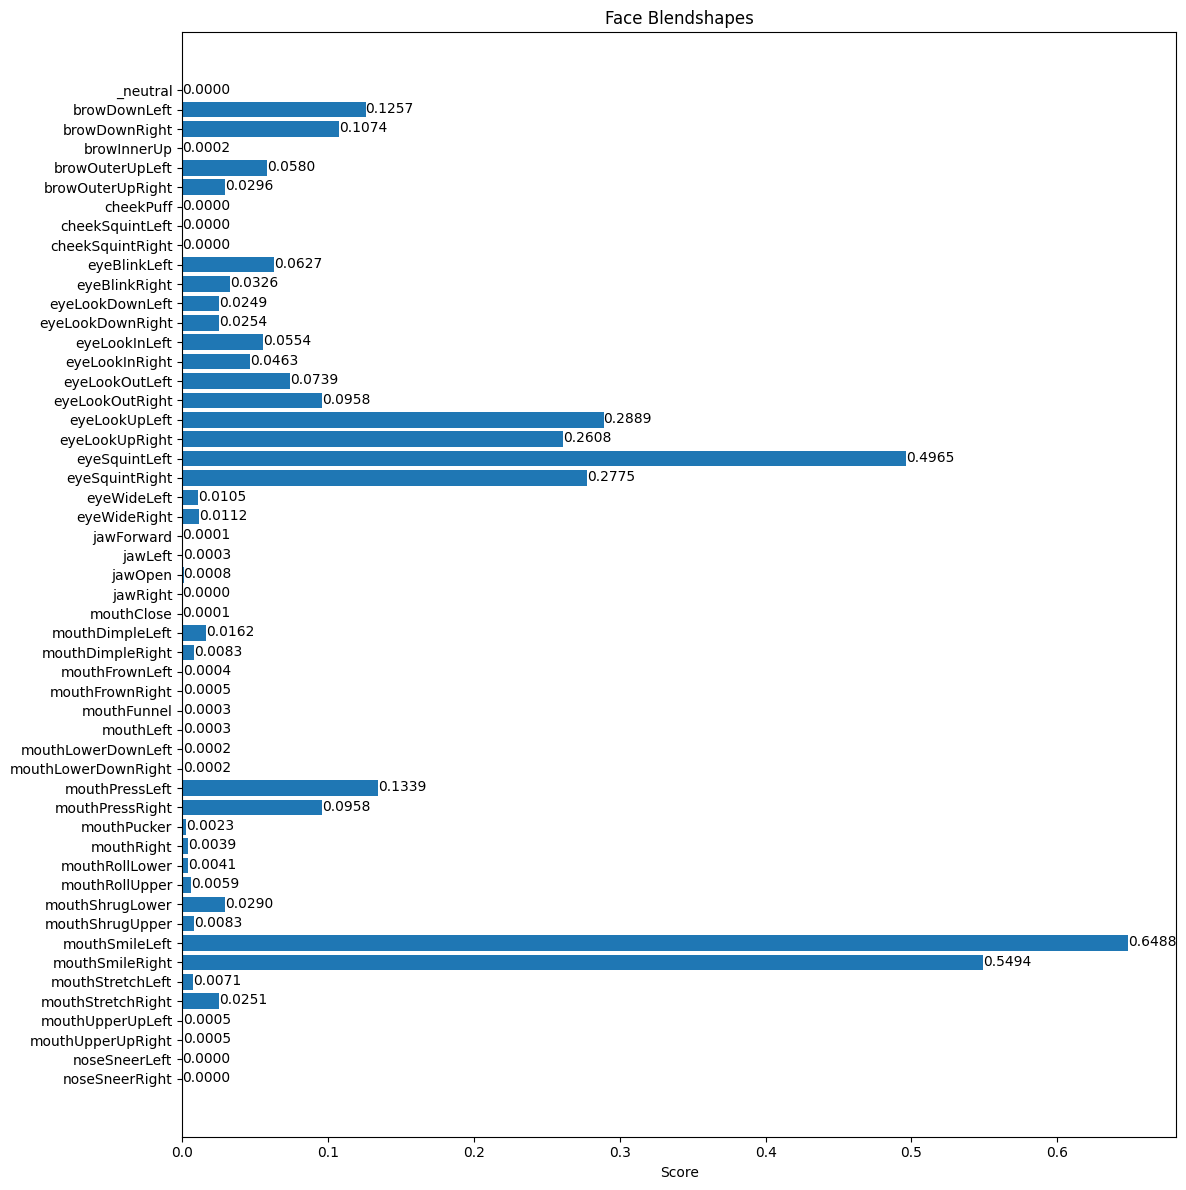

In [3]:
# 막대 그래프로 얼굴 블렌디쉐이프 카테고리 시각화
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [4]:
# 변환 행렬 출력
print(detection_result.facial_transformation_matrixes)

[array([[ 9.92205501e-01, -6.04903474e-02,  1.08946197e-01,
         1.18711746e+00],
       [ 9.10740122e-02,  9.48733926e-01, -3.02671373e-01,
         2.23701134e+01],
       [-8.50522369e-02,  3.10234487e-01,  9.46847558e-01,
        -6.80049210e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


# 라이브 스트림

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

model_path = '/absolute/path/to/face_landmarker.task'

BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
FaceLandmarkerResult = mp.tasks.vision.FaceLandmarkerResult
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a face landmarker instance with the live stream mode:
def print_result(result: FaceLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    print('face landmarker result: {}'.format(result))

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.LIVE_STREAM,
    result_callback=print_result)

with FaceLandmarker.create_from_options(options) as landmarker:
    # The landmarker is initialized. Use it here.
    # ...

# Use OpenCV’s VideoCapture to start capturing from the webcam.

# Create a loop to read the latest frame from the camera using VideoCapture#read()

# Convert the frame received from OpenCV to a MediaPipe’s Image object.
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)

# Send live image data to perform face landmarking.
# The results are accessible via the `result_callback` provided in
# the `FaceLandmarkerOptions` object.
# The face landmarker must be created with the live stream mode.
landmarker.detect_async(mp_image, frame_timestamp_ms) 

In [29]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# 절대 경로를 설정합니다.
model_path = 'face_landmarker_v2_with_blendshapes.task'

# 필요한 클래스 및 모듈을 가져옵니다.
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
FaceLandmarkerResult = mp.tasks.vision.FaceLandmarkerResult
VisionRunningMode = mp.tasks.vision.RunningMode

# 얼굴 랜드마킹 결과를 출력하는 콜백 함수 정의
def print_result(result: FaceLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    print('face landmarker result: {}'.format(result))

# FaceLandmarker 옵션 설정
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.LIVE_STREAM,
    result_callback=print_result)

# FaceLandmarker 인스턴스 생성
with FaceLandmarker.create_from_options(options) as landmarker:
    # OpenCV를 사용하여 웹캠에서 비디오 캡처 시작
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        exit()

    while True:
        # 최신 프레임 읽기
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        # OpenCV 프레임을 MediaPipe 이미지 객체로 변환
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # 현재 타임스탬프 가져오기 (밀리초 단위)
        frame_timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))

        # 비동기 얼굴 랜드마킹 수행
        landmarker.detect_async(mp_image, frame_timestamp_ms)

        # 프레임을 화면에 표시
        cv2.imshow('Webcam', frame)

        # 'q' 키를 누르면 종료
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # 웹캠 및 모든 윈도우 해제
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1719397721.095202   70382 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1719397721.095402   70382 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
[ WARN:0@1495.536] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1495.603] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


Error: Could not open webcam.
Error: Could not read frame.


: 